# Example 3. Adaptive Boosting
---
The alternative ensemble algorithm is similar to kids learning experience when the teacher gives the reward and punishment for the good and bad homework, respectively, to have next improvement. The algorithm is called **Adaptive Boosting**. It uses the *weak learner* iteratively to learn several weak models by weighting and emphasizing the miss-classified data, and then aggregates them to a *strong model*. Since the algorithm is using a weak learner, i.e. it provides a simple and straightforward model, there must be some miss-classificatied data, which can be used for next weak model's training. By giving the weights to the miss-classificatied data and training the another weak model, the algorithm will obtain many models, when it iteratively proccesses (boosts the model) the same procedures again and again. During the iterations, each model can have the different predictions adaptively for the new weighted dataset. In the end, basing on those different predictions, the algorithm can use the voting aggregation method to give a robust model and better preditions. It is therefore expected to have non-linear prediction and less overfitting issue. But it only works for using the weak learner, i.e. the learner is very simple, e.g. thin-depth decision tree or perceptron. The random forest algorithm is actually basing on the adaptive boosting algorithm from the decision trees. 

The following figure shown the ideal procedure of **adaptive boosting**. The straight line is the weak learner, and the enlarged/shrank markers represent the weighted data due to the miss/correct classifition from the prevoious weak model: 
![adabost](../doc/adaboost.png)

---
However, the procedures of weight updating is defined as following:
1. Initialize the data weights to be equal and 
$$
\begin{split}
\\
\sum_i w_i=1\ .
\\
\end{split}
$$
2. Train a weak model, $m$, from weak learner, $C$ ,by data, $X=\{X_1,\,X_2,\dots,\,X_i\}$, and obtain the prediction, $y'_i$.
3. Cacualte the **weight error**
$$
\begin{split}
\\
\epsilon_m = \sum_i w_i\delta_i\ ,
\\
\end{split}
$$
where $\delta_i=0$ and $1$ when $y_i=y'_i$ and $y_i\neq y'_i$, respectively.
4. Caculate the **data weight update**
$$
\begin{split}
\\
\boxed{w'_i=w_ie^{-y_iy'_i\alpha_m}\ }\ ,
\\
\end{split}
$$
where the $\alpha_m$ is the update parameter and defined as
$$
\begin{split}
\\
\alpha_m=\frac{1}{2}\log\frac{1-\epsilon_m}{\epsilon_m}\ .
\\
\end{split}
$$
5. Nomalize the data weight and apply it to the data
$$
\begin{split}
\\
\boxed{w_i\to \frac{w'_i}{\sum_i w'_i}\ }\ ,
\\
\end{split}
$$
6. Iterate the procedures **2.-5.** for next weak model training.
---

According to the procedure **4.**, we know the weight for the miss-predicted data, $y_i\neq y'_i$, will be enlarged exponentially, while the weight is reduced for the correct predicted data, $y_i=y'_i$.

### Import package and data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing   import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics         import accuracy_score

In [2]:
le = LabelEncoder()
df_wine = pd.read_csv('../data/wine.data')
df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash', 
                   'Alcalinity of ash', 'Magnesium', 'Total phenols', 'Flavanolds', 
                   'Nonflavanoid phenols', 'Proanthocyanins', 'Color intensity', 
                   'Hue', 'OD280/OD315 of diluted wines', 'Proline']
# Only use class 2 and 3
df_wine = df_wine[df_wine['Class label']!=1]
y = le.fit_transform(df_wine['Class label'].values)
X = df_wine[['Alcohol', 'Hue']].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=1)

In [3]:
def accuracy( model, X, y ):
    y_pred = model.predict(X)
    return accuracy_score(y, y_pred)

In [4]:
def decision_regions( models, titles, X, y ):
    x_min = X[:, 0].min() - 1
    x_max = X[:, 0].max() + 1
    y_min = X[:, 1].min() - 1
    y_max = X[:, 1].max() + 1 
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))
    f, axarr = plt.subplots(nrows=1, ncols=2, sharex='col', sharey='row', figsize=(10,5))

    for idx, clf, label in zip([0, 1], models, titles):
        #clf.fit(X, y)
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        axarr[idx].contourf(xx, yy, Z, alpha=0.3)
        axarr[idx].scatter( X[y==0,0], X[y==0,1], c='blue', marker='^', s=50)
        axarr[idx].scatter( X[y==1,0], X[y==1,1], c='red',  marker='o', s=50) 
        axarr[idx].set_title(label)

    axarr[0].set_ylabel('Alcohol', fontsize=12)
    plt.text(10,  -0.8, s='Hue',     ha='center', va='center', fontsize=12)
    #plt.text(4.5, 1,    s='Alcohol', ha='center', va='center', fontsize=12, rotation=90)
    plt.show()

### 1. Weak models

In [5]:
from sklearn.linear_model import Perceptron
from sklearn.tree         import DecisionTreeClassifier

#### 1.1. 1-depth Decision tree

In [6]:
tree = DecisionTreeClassifier(criterion='entropy', max_depth=1)
tree = tree.fit(X_train, y_train)
print 'Decision tree train/test accuracies: %.3f/%.3f'%( accuracy(tree, X_train, y_train), 
                                                         accuracy(tree, X_test,  y_test))

Decision tree train/test accuracies: 0.845/0.854


#### 1.2. Single Perceptron

In [7]:
pla = Perceptron(n_iter=20, eta0=0.01, random_state=0)
pla.fit(X_train, y_train)
print 'PLA train/test accuracies: %.3f/%.3f'%( accuracy(pla, X_train, y_train), 
                                               accuracy(pla, X_test,  y_test))

PLA train/test accuracies: 0.817/0.875


### 2. AdaBoosting the weak learners
#### 2.1. Training the weak learners

In [8]:
from sklearn.ensemble import AdaBoostClassifier

In [9]:
ada_tree  = AdaBoostClassifier(base_estimator=tree,
                               n_estimators=500,
                               learning_rate=0.1,
                               random_state=0)
ada_tree = ada_tree.fit(X_train, y_train)
print 'AdaBoost tree train/test accuracies: %.3f/%.3f'%(accuracy(ada_tree, X_train, y_train), 
                                                        accuracy(ada_tree, X_test,  y_test))

AdaBoost tree train/test accuracies: 1.000/0.875


In [10]:
ada_pla = AdaBoostClassifier(base_estimator=pla,
                             n_estimators=500,
                             learning_rate=0.1,
                             random_state=0,
                             algorithm='SAMME')
ada_pla = ada_pla.fit(X_train, y_train)
print 'AdaBoost tree train/test accuracies: %.3f/%.3f'%(accuracy(ada_pla, X_train, y_train), 
                                                        accuracy(ada_pla, X_test,  y_test))

AdaBoost tree train/test accuracies: 0.944/0.896


#### 2.2. Visualization of decision regions

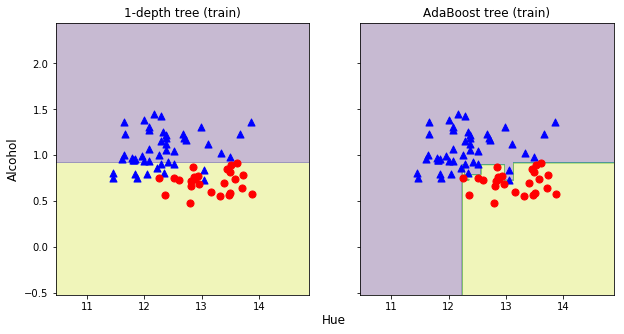

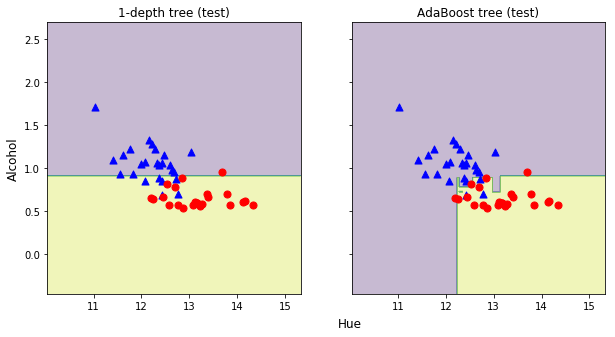

In [11]:
decision_regions([tree, ada_tree], ['1-depth tree (train)', 'AdaBoost tree (train)'], X_train, y_train)
decision_regions([tree, ada_tree], ['1-depth tree (test)', 'AdaBoost tree (test)'],   X_test, y_test)

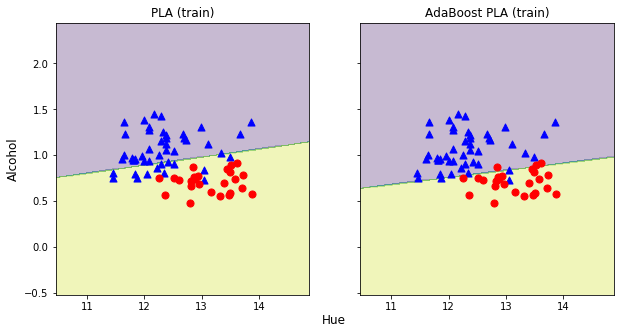

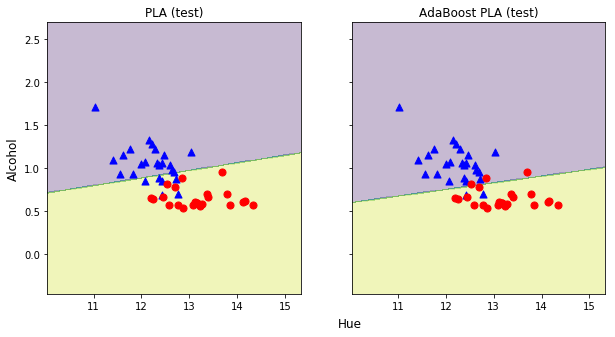

In [12]:
decision_regions([pla, ada_pla], ['PLA (train)', 'AdaBoost PLA (train)'], X_train, y_train)
decision_regions([pla, ada_pla], ['PLA (test)',  'AdaBoost PLA (test)'],  X_test, y_test)

In [13]:
pla.coef_

array([[ 0.0909 , -1.03522]])

In [14]:
pla.intercept_

array([-0.17])